## Verrijkte kleinverbruikergegevens
Creer een nieuwe dataset obv de NEDU profielen en de kleinverbruikergegevens. De nieuwe dataset bevat dan het kleinverbruik per dag per postcode.

De stappen die genomen worden zijn:

1. Inlezen h5 bestanden met de NEDU profielen en kleinverbruikergegevens
2. Voeg profiel toe aan kleinverbruikergegevens
3. Transformeer NEDU profielen set tot een verbruik per dag ipv verbruik per kwartier
4. Nieuw dataframe opbouwen met per dag de volgende data:
* Datum
* Verbruik
* Postcode
* Aantal aansluitingen

Om het juiste profiel te bepalen nemen we 2 dingen mee:
* Wat is percentage meters met een Laag/Hoog tarief. Als dit percentage lager is dan 30% wordt het gebied in een A profiel gezet.
* Ligt het gebied in Noord of Zuid-Nederland. Dit wordt gebruikt om te bepalen of het gebied een E1B of E1C profiel krijgt.

Het verbruik wordt berekend door het verbruik van het profiel behorende bij de postcode te sommeren voor een dag.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# show all columns in the dataframe
pd.set_option('max_columns', None)

In [2]:
os.getcwd()

'c:\\Users\\ericr\\OneDrive - Actondata\\Projecten\\jads_enexis\\notebooks'

In [3]:
# variables used in script
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

# kleinverbruikgegevens gegevens inlezen
df_verbruik = pd.read_hdf('kleinverbruikgegevens_data.h5')

# NEDU profielen
df_nedu_profielen = pd.read_hdf('nedu_files.h5')
df_transform_nedu = pd.read_hdf('nedu_files_transformed.h5')

# mapping van PC4 buurt naar RES regio
df_pc4_res = pd.read_hdf('pc4_res.h5')

In [4]:
# Laat alle soorten aansluitingen zien
df_verbruik.SOORT_AANSLUITING.unique()

array(['1X25', '3X25', '1X35', '3X35', '3X63', '1X40', '3X80', '3X50',
       '1X20', '3X40', '1x25', '3x25', '1x35', '1x40', '3x35', '3x63',
       '3x80', '3x50', '3x40', '1x20'], dtype=object)

In [5]:
# Laat alle soorten laag tarief percentage zien
df_verbruik.SJV_LAAG_TARIEF_PERC.unique()

array([25.  , 10.  , 34.  , ..., 71.81, 71.08, 78.39])

In [6]:
provincie_limburg = ['61', '62', '63', '64']
provincie_brabant = ['42', '46', '47', '48', '49', '50', '51', '52', '53', '44', '55', '56', '57', '58', '60', '97']
profiel_E1 = ['1X25', '1x25', '3X25', '3x25', '1X20','1x20'] # de rest is profiel E2

# Voeg in de kleinverbruikgegevens, het bijpassende profiel voor de soort aansluiting toe
def vervang_door_profiel(aansluiting, postcode, percentage):
    # Bepaal basisprofiel
    profiel = 'E1' if aansluiting in profiel_E1 else 'E2'

    # Een laag tarief percentage lager dan 30% zetten we in een A profiel
    lh_profiel = 'A' if percentage < 30 else 'B'

    # Bepaal welk laag tarief gebied de postcode zit
    if profiel == 'E1' and lh_profiel == 'B':
        postcode_area = postcode[:2] # PC4
        if postcode_area in provincie_brabant or postcode_area in provincie_limburg:
            lh_profiel = 'C'
    return profiel + lh_profiel

df_verbruik["PROFIEL"] = np.vectorize(vervang_door_profiel)(df_verbruik.SOORT_AANSLUITING, df_verbruik.POSTCODE_VAN, df_verbruik.SJV_LAAG_TARIEF_PERC)
df_verbruik.head()

,NETBEHEERDER,NETGEBIED,STRAATNAAM,POSTCODE_VAN,POSTCODE_TOT,WOONPLAATS,LANDCODE,PRODUCTSOORT,VERBRUIKSSEGMENT,LEVERINGSRICHTING_PERC,AANSLUITINGEN_AANTAL,FYSIEKE_STATUS_PERC,SOORT_AANSLUITING_PERC,SOORT_AANSLUITING,SJV_GEMIDDELD,SJV_LAAG_TARIEF_PERC,SLIMME_METER_PERC,JAAR,PC4,SJV_TOTAAL,PROFIEL
0,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,NL,ELK,KVB,100.0,16,100,0.0,1X25,4282.0,25.0,0.0,2010,4251,69.0,E1A
1,Enexis B.V.,ENEXIS,Sasdijk,4251AC,4251AC,WERKENDAM,NL,ELK,KVB,100.0,11,100,0.0,1X25,5113.0,10.0,0.0,2010,4251,56.0,E1A
2,Enexis B.V.,ENEXIS,Sasdijk,4251AD,4251AD,WERKENDAM,NL,ELK,KVB,100.0,30,100,0.0,3X25,4809.0,34.0,0.0,2010,4251,144.0,E1C
3,Enexis B.V.,ENEXIS,Nieuweweg,4251AE,4251AG,WERKENDAM,NL,ELK,KVB,100.0,21,100,0.0,1X25,5015.0,44.0,0.0,2010,4251,105.0,E1C
4,Enexis B.V.,ENEXIS,Koppenhof,4251AH,4251AH,WERKENDAM,NL,ELK,KVB,100.0,12,100,0.0,1X25,3074.0,22.0,0.0,2010,4251,37.0,E1A


In [7]:
from datetime import datetime
import math

# Voeg een datum kolom toe zodat we kunnen aggreren per datum per profiel
def haal_datum_op(datum):
    datum = pd.to_datetime(datum)
    # Laatste rij is blijkbaar NaN. 
    if math.isnan(datum.year):
        return ''
    return datetime(datum.year,datum.month,datum.day)
df_nedu_profielen["DATUM"] = np.vectorize(haal_datum_op)(df_nedu_profielen.Start)

# Groepeer op datum en sommeer de profielen die we nodig hebben
df_nedu_gereduceerd = df_nedu_profielen.groupby('DATUM').agg({'E1A':'sum', 'E1B':'sum', 'E1C':'sum', 'E2A':'sum', 'E2B':'sum'})

# Sorteer op datum
df_nedu_gereduceerd = df_nedu_gereduceerd.sort_values(by='DATUM')
print (f"Aantal rijen in de NEDU set = {df_nedu_gereduceerd.shape[0]}")

# Check de eerste paar rijen.
df_nedu_gereduceerd.head()

Aantal rijen in de NEDU set = 4383


,E1A,E1B,E1C,E2A,E2B
DATUM,,,,,
2010-01-01,0.003261,0.003344,0.003464,0.001992,0.002531
2010-01-02,0.003144,0.003115,0.003006,0.003491,0.003126
2010-01-03,0.003003,0.002898,0.002952,0.003190,0.002986
2010-01-04,0.002622,0.002546,0.002759,0.003222,0.002895
2010-01-05,0.002518,0.002503,0.002419,0.001884,0.002260


# Test dataframe voor 1 PC4

In [8]:
### alleen nodig om nedu_files_transformed.h5 opnieuw aan te maken

# df_transform_nedu = pd.DataFrame(columns=["DATUM", "PROFIEL", "VERBRUIKS_FACTOR"])
# for index,row in df_nedu_gereduceerd.iterrows():
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E1A", "VERBRUIKS_FACTOR":row.E1A}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E1B", "VERBRUIKS_FACTOR":row.E1B}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E1C", "VERBRUIKS_FACTOR":row.E1C}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E2A", "VERBRUIKS_FACTOR":row.E2A}, ignore_index=True)
#     df_transform_nedu = df_transform_nedu.append({"DATUM":index, "PROFIEL":"E2B", "VERBRUIKS_FACTOR":row.E2B}, ignore_index=True)

# # we voegen er nog een jaar aan toe om met verbuik dataset te kunnen joinen
# df_transform_nedu['JAAR'] = df_transform_nedu['DATUM'].dt.year

# df_transform_nedu.head()

,DATUM,PROFIEL,VERBRUIKS_FACTOR,JAAR
0,2010-01-01,E1A,0.003261,2010
1,2010-01-01,E1B,0.003344,2010
2,2010-01-01,E1C,0.003464,2010
3,2010-01-01,E2A,0.001992,2010
4,2010-01-01,E2B,0.002531,2010


In [9]:
### alleen nodig om nedu_files_transformed.h5 opnieuw aan te maken

# data_processed_location = '../data/processed'

# if 'processed' not in os.getcwd():
#     os.chdir(data_processed_location)

# try:
#     os.remove('nedu_files_transformed.h5')
# except:
#     print ('File nog in gebruik of niet gevonden')

# store = pd.HDFStore('nedu_files_transformed.h5')
# store['nedu_files_transformed'] = df_transform_nedu
# store.close()

In [10]:
# RES toevoegen aan vebruik dataframe
df_verbruik['PC4'] = df_verbruik['PC4'].astype('int64')
df_verbruik = pd.merge(df_verbruik, df_pc4_res, on=['PC4'], how='left')

In [11]:
# een sample nemen uit de verbruiks data 
# en deze joinen met de df_transform_nedu data
df_sample = df_verbruik[['RES','PC4','JAAR','SJV_TOTAAL','PROFIEL']][df_verbruik['PC4'] == 4251
                                                                ]
df_sample = pd.merge(df_sample, df_transform_nedu, on=['JAAR','PROFIEL'], how='left')

# verbruik per dag berekenen
df_sample['VERBRUIK'] =  df_sample['SJV_TOTAAL'] * df_sample['VERBRUIKS_FACTOR']

# df_verbruik is nog per pc6, dus eerst omzetten naar pc4
df_sample_pc4 = df_sample.groupby(['RES','PC4','DATUM'], as_index=False).agg(VERBRUIK = ('VERBRUIK', 'sum'))
df_sample_pc4 = pd.DataFrame(df_sample_pc4[['DATUM','VERBRUIK']]).set_index('DATUM')
df_sample_pc4.head()

,VERBRUIK
DATUM,
2010-01-01,69.210361
2010-01-02,67.161735
2010-01-03,64.971068
2010-01-04,60.439058
2010-01-05,52.102170


In [12]:
df_sample_pc4.index.year.value_counts()

2012    366
2016    366
2020    366
2013    365
2017    365
2021    365
2010    365
2014    365
2018    365
2011    365
2015    365
2019    365
Name: DATUM, dtype: int64

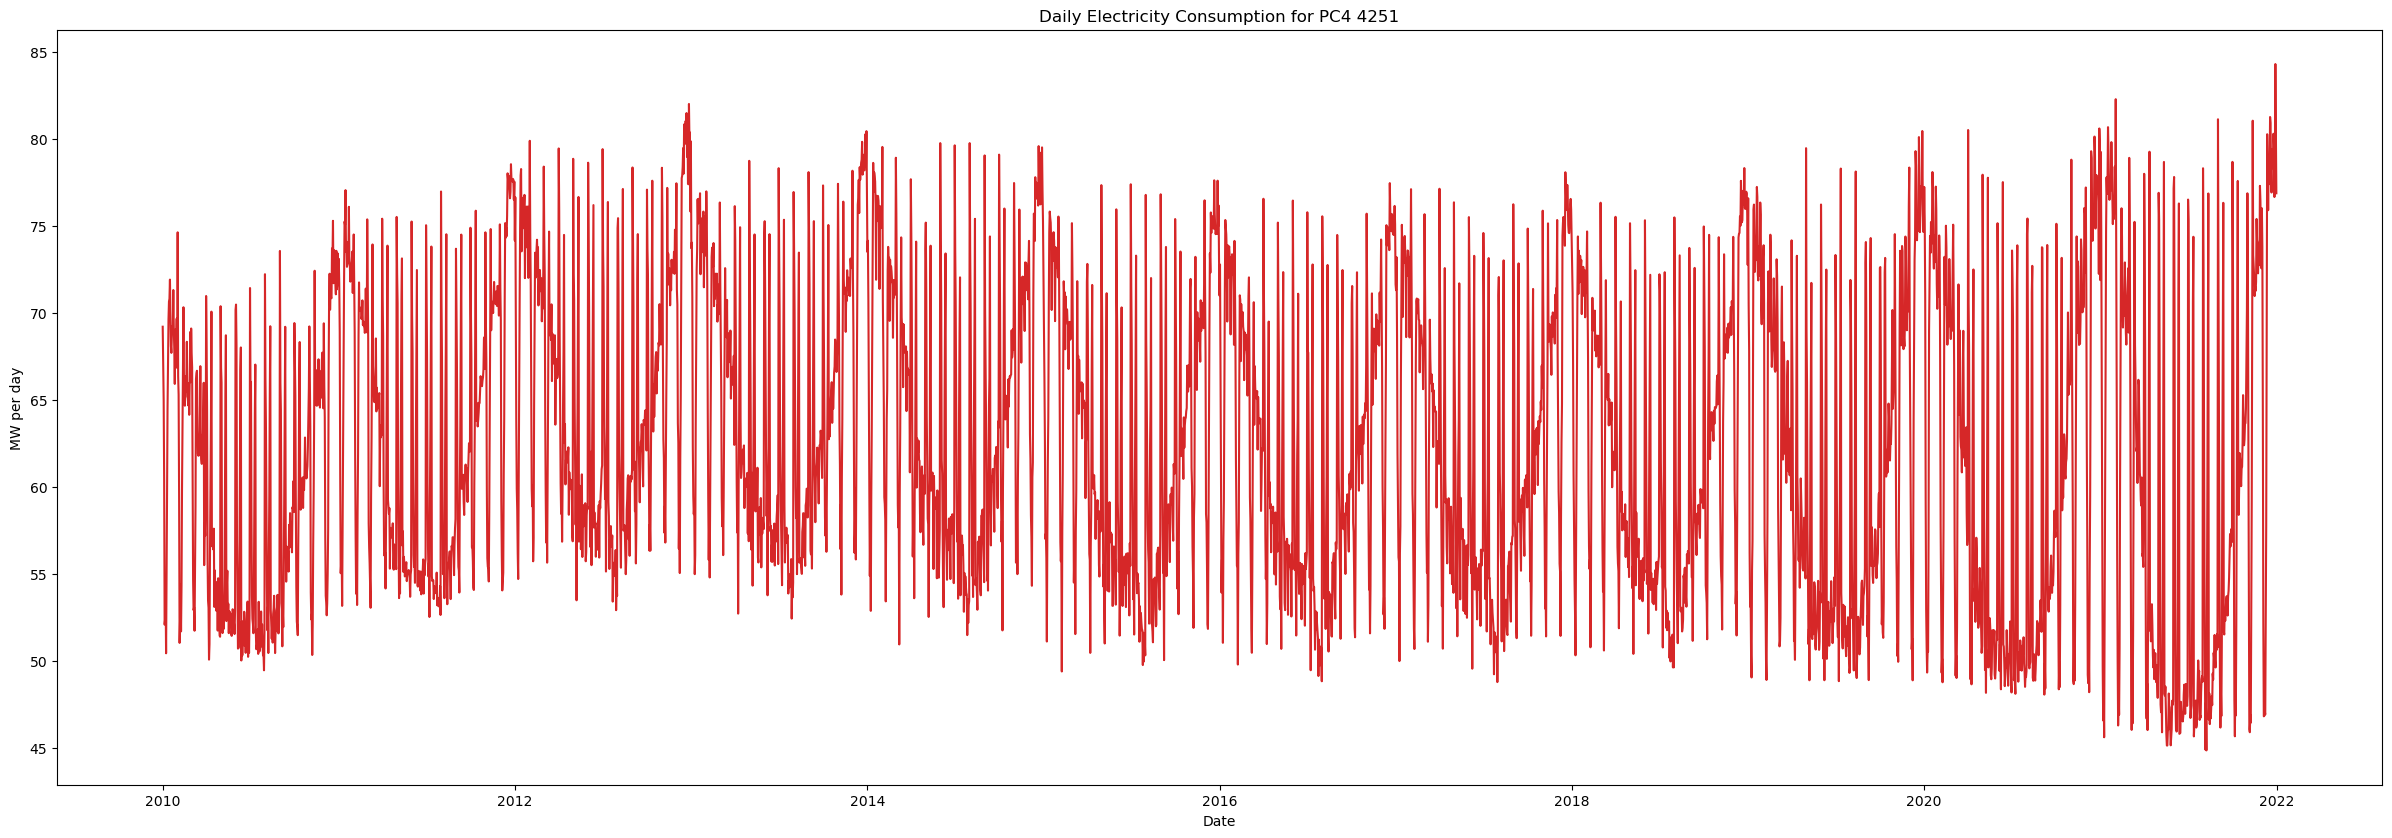

In [13]:
# Time series plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='MW per day', dpi=100):
    plt.figure(figsize=(30,10), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_sample_pc4, x=df_sample_pc4.index, y=df_sample_pc4['VERBRUIK'], title='Daily Electricity Consumption for PC4 4251')  

In [14]:
df_sample_pc4.head()

,VERBRUIK
DATUM,
2010-01-01,69.210361
2010-01-02,67.161735
2010-01-03,64.971068
2010-01-04,60.439058
2010-01-05,52.102170


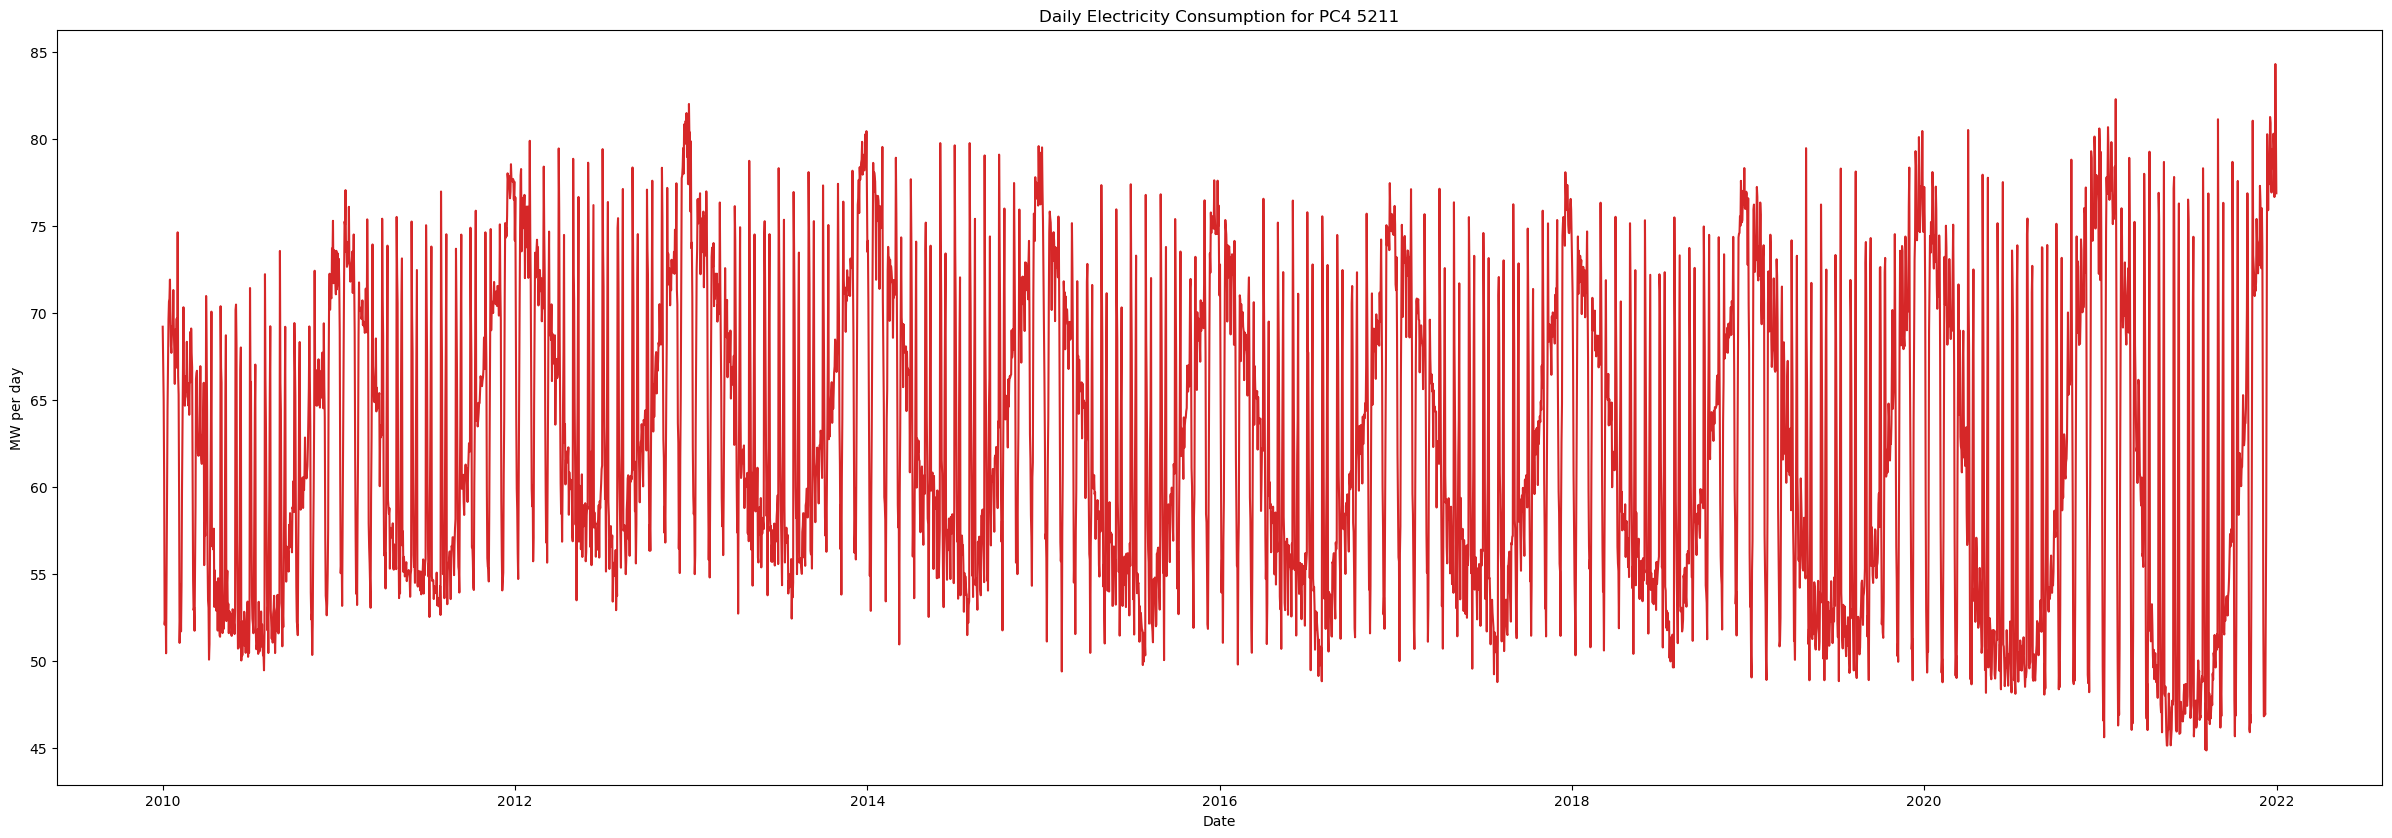

In [15]:
# Time series plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='MW per day', dpi=100):
    plt.figure(figsize=(30,10), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_sample_pc4, x=df_sample_pc4.index, y=df_sample_pc4['VERBRUIK'], title='Daily Electricity Consumption for PC4 5211')  

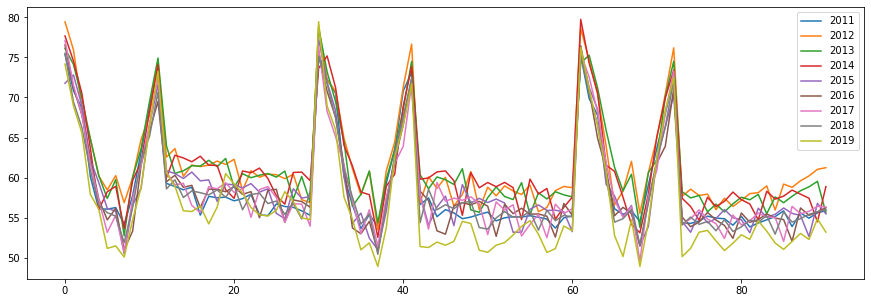

In [18]:
# Set start and end dates mm-dd
start_date='04-01'
end_date ='06-30'

# Set year range
start_year = 2011
end_year = 2019


# set up plot
fig, ax = plt.subplots(figsize=(15,5))

# Loop over years in year_range
for year in range(start_year,end_year+1):
    start_index = str(year)+'-'+start_date
    end_index = str(year)+'-'+end_date
    df=df_sample_pc4[start_index:end_index].reset_index()
    ax.plot(df['VERBRUIK'], label=str(year))
    ax.legend()

In [17]:
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

try:
    os.remove('pc4_verbruiksdata_per_dag_5211.h5')
except:
    print ('File nog in gebruik of niet gevonden')

store = pd.HDFStore('pc4_verbruiksdata_per_dag_5211.h5')
store['pc4_verbruiksdata_per_dag_5211'] = df_sample_pc4
store.close()

# Einde Test dataframe voor 1 PC4

In [15]:
# Manier 1. Eerst aantal rijen reduceren tot PC4 en daarna NEDU data invoegen. Wat doen we dan met het profiel?
print (f"Aantal rijen voor reductie = {df_verbruik.shape[0]}")

# groepeer de kleinverbruiker gegevens op PC4 level. Om het gemiddelde profiel te bepalen maken we een custom functie 'bepaal_profiel', die de profielen telt
def bepaal_profiel(series):
    profielen = series.value_counts()

    e1_counts = e2_counts = 0
    for index, value in profielen.items():
        if index[:2] == 'E1':
            e1_counts = e1_counts + value
        else:
            e2_counts = e2_counts + value
    #print (e1_counts, e2_counts)
#profiel = profielen[profielen == max(profielen)].index.values[0]            
    return 'E1B' if e1_counts > e2_counts else 'E2B'

df_verbruik_gereduceerd = df_verbruik.groupby('PC4').agg({'PROFIEL':bepaal_profiel, 'SJV_GEMIDDELD':'sum', 'AANSLUITINGEN_AANTAL':'sum', 'LEVERINGSRICHTING_PERC': 'mean'})

print(f"Aantal rijen na reductie = {df_verbruik_gereduceerd.shape[0]}")

print(f"Aantal E1 profielen = {df_verbruik_gereduceerd[df_verbruik_gereduceerd.PROFIEL == 'E1B'].shape[0]}")
print(f"Aantal E2 profielen = {df_verbruik_gereduceerd[df_verbruik_gereduceerd.PROFIEL == 'E2B'].shape[0]}")

df_verbruik_gereduceerd.head()

Aantal rijen voor reductie = 1391390
Aantal rijen na reductie = 1647
Aantal E1 profielen = 1250
Aantal E2 profielen = 397


,PROFIEL,SJV_GEMIDDELD,AANSLUITINGEN_AANTAL,LEVERINGSRICHTING_PERC
PC4,,,,
4251,E1B,13465001.46,54965,96.440601
4254,E1B,6083345.90,27539,92.992643
4255,E1B,3748403.28,18855,92.143663
4261,E1B,7353945.13,29104,96.062108
4264,E1B,3598768.56,14406,96.719964


In [16]:
# Manier 2. We maken een dictionary van postcode naar {#aansluitingen, dateframe met NEDU profiel data} en zetten die om naar een dataframe

# Testje met een minimale dictionary
data = { 'POSTCODE': '4251AB', 'AANSLUITINGEN_AANTAL' : 10, 'LEVERINGSRICHTING_PERC' : 34, 'VERBRUIK': {'2010-01-01': 12, '2010-01-02': 15}}
pd.DataFrame.from_dict(data)

,POSTCODE,AANSLUITINGEN_AANTAL,LEVERINGSRICHTING_PERC,VERBRUIK
2010-01-01,4251AB,10,34,12
2010-01-02,4251AB,10,34,15


In [17]:
# Manier 3. We gebruik de merge methode van pandas. We proberen te mergen op profiel. Hiervoor moet het profielen dataframe wel van structuur veranderen
# Structuur moet worden datum, profiel, verbruik. Dan kunnen we op Profiel proberen te mergen.

# Dit kan vast sneller met een goede pivot of eerst een dictionary opbouwen maar het werkt
df_transform_nedu = pd.DataFrame(columns=["Datum", "Profiel", "Verbruik"])
for index,row in df_nedu_gereduceerd.iterrows():
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E1A", "Verbruik":row.E1A}, ignore_index=True)
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E1B", "Verbruik":row.E1B}, ignore_index=True)
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E1C", "Verbruik":row.E1C}, ignore_index=True)
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E2A", "Verbruik":row.E2A}, ignore_index=True)
    df_transform_nedu = df_transform_nedu.append({"Datum":index, "Profiel":"E2B", "Verbruik":row.E2B}, ignore_index=True)
df_transform_nedu

,Datum,Profiel,Verbruik
0,2010-01-01,E1A,0.003261
1,2010-01-01,E1B,0.003344
2,2010-01-01,E1C,0.003464
3,2010-01-01,E2A,0.001992
4,2010-01-01,E2B,0.002531
...,...,...,...
21910,2021-12-31,E1A,0.003380
21911,2021-12-31,E1B,0.003566
21912,2021-12-31,E1C,0.003775
21913,2021-12-31,E2A,0.002839


In [18]:
df_transform_nedu['Verbruik'].sum()

60.04633696

In [19]:
import time

# Build a frame per PC4
print ("Lijst met PC4 codes samenstellen", end="..")
PC4_list = df_verbruik.PC4.unique()
pc4_count = len(PC4_list)
print (f"done. Er zijn {pc4_count} pc4 codes")

# First PC4 area in de lijst
first_pc4 = PC4_list[0]

# Schrijf het samengevoegde dataframe naar een bestand
def write_h5(df):
    file = f"pc4_verbruiksdata"

    # Haal een eventuele vorige versie weg
    try:
        os.remove(file + '.h5')
    except:
        # Schrijf het bestand weg
        store = pd.HDFStore(file + '.h5')
        store[file] = df
        store.close()

# Gebruik data van 1 jaar. Anders krijgen we te veel
print ("Filter kleinverbruik data voor 2020", end="..")
df_verbruik = df_verbruik[df_verbruik.JAAR == 2020]
print (f"done")

# Per pc4 area maak een samengevoegd dataframe
i = 1
df_end_frame = None
def do_per_pc4(pc4):
    global i, df_end_frame
    start = time.time()

    print(f'{format(i,"04d")}. Samenvoegen profielen en verbruiksdata voor {pc4}', end = '..')
    i = i + 1

    # Maak kleiner frame
    df_verbruik_pc4 = df_verbruik[df_verbruik.PC4 == pc4]
    
    # Voeg samen met de profielen set
    df_merge = pd.merge(df_verbruik_pc4, df_transform_nedu, left_on=['PROFIEL'], right_on=['Profiel'])

    # Pak alleen de kolommen die we willen hebben
    df_merge = df_merge[['Datum', 'JAAR', 'Verbruik', 'PC4', 'LEVERINGSRICHTING_PERC', 'AANSLUITINGEN_AANTAL', 'PROFIEL', 'SJV_GEMIDDELD', 'PROFIEL']]

    # rol op per pc4 gebied
    df_merge = df_merge.groupby(['Datum', 'PC4']).agg({'Verbruik': 'sum'})

    if df_end_frame is None:
        df_end_frame = df_merge.copy()
    else:
        df_end_frame = df_end_frame.append(df_merge)

    end = time.time()
    exec_tijd = format(end - start, '.1f')
    print(f'done in {exec_tijd}s')

    return df_merge

# Doe voor alle pc4 entries
for pc4 in PC4_list:
    do_per_pc4(pc4)

# Schrijf bestand weg
write_h5(df_end_frame)

Lijst met PC4 codes samenstellen..done. Er zijn 1647 pc4 codes
Filter kleinverbruik data voor 2020..done
0001. Samenvoegen profielen en verbruiksdata voor 4251..done in 0.9s
0002. Samenvoegen profielen en verbruiksdata voor 4254..done in 0.5s
0003. Samenvoegen profielen en verbruiksdata voor 4255..done in 0.3s
0004. Samenvoegen profielen en verbruiksdata voor 4261..done in 0.5s
0005. Samenvoegen profielen en verbruiksdata voor 4264..done in 0.2s
0006. Samenvoegen profielen en verbruiksdata voor 4265..done in 0.1s
0007. Samenvoegen profielen en verbruiksdata voor 4266..done in 0.1s
0008. Samenvoegen profielen en verbruiksdata voor 4267..done in 0.0s
0009. Samenvoegen profielen en verbruiksdata voor 4268..done in 0.1s
0010. Samenvoegen profielen en verbruiksdata voor 4269..done in 0.0s
0011. Samenvoegen profielen en verbruiksdata voor 4271..done in 0.2s
0012. Samenvoegen profielen en verbruiksdata voor 4273..done in 0.4s
0013. Samenvoegen profielen en verbruiksdata voor 4281..done in 0.2

0118. Samenvoegen profielen en verbruiksdata voor 4874..done in 0.3s
0119. Samenvoegen profielen en verbruiksdata voor 4875..done in 0.2s
0120. Samenvoegen profielen en verbruiksdata voor 4876..done in 0.5s
0121. Samenvoegen profielen en verbruiksdata voor 4877..done in 0.1s
0122. Samenvoegen profielen en verbruiksdata voor 4878..done in 0.1s
0123. Samenvoegen profielen en verbruiksdata voor 4879..done in 0.1s
0124. Samenvoegen profielen en verbruiksdata voor 4881..done in 0.7s
0125. Samenvoegen profielen en verbruiksdata voor 4882..done in 0.2s
0126. Samenvoegen profielen en verbruiksdata voor 4884..done in 0.2s
0127. Samenvoegen profielen en verbruiksdata voor 4885..done in 0.2s
0128. Samenvoegen profielen en verbruiksdata voor 4891..done in 0.5s
0129. Samenvoegen profielen en verbruiksdata voor 4901..done in 0.9s
0130. Samenvoegen profielen en verbruiksdata voor 4902..done in 0.7s
0131. Samenvoegen profielen en verbruiksdata voor 4903..done in 0.1s
0132. Samenvoegen profielen en ver

0237. Samenvoegen profielen en verbruiksdata voor 5233..done in 0.7s
0238. Samenvoegen profielen en verbruiksdata voor 5234..done in 0.1s
0239. Samenvoegen profielen en verbruiksdata voor 5235..done in 0.7s
0240. Samenvoegen profielen en verbruiksdata voor 5236..done in 0.5s
0241. Samenvoegen profielen en verbruiksdata voor 5237..done in 0.7s
0242. Samenvoegen profielen en verbruiksdata voor 5241..done in 0.6s
0243. Samenvoegen profielen en verbruiksdata voor 5242..done in 0.4s
0244. Samenvoegen profielen en verbruiksdata voor 5243..done in 0.3s
0245. Samenvoegen profielen en verbruiksdata voor 5244..done in 0.3s
0246. Samenvoegen profielen en verbruiksdata voor 5245..done in 0.2s
0247. Samenvoegen profielen en verbruiksdata voor 5246..done in 0.6s
0248. Samenvoegen profielen en verbruiksdata voor 5247..done in 0.6s
0249. Samenvoegen profielen en verbruiksdata voor 5248..done in 0.2s
0250. Samenvoegen profielen en verbruiksdata voor 5249..done in 0.1s
0251. Samenvoegen profielen en ver

0355. Samenvoegen profielen en verbruiksdata voor 5492..done in 0.7s
0356. Samenvoegen profielen en verbruiksdata voor 5501..done in 0.5s
0357. Samenvoegen profielen en verbruiksdata voor 5502..done in 0.5s
0358. Samenvoegen profielen en verbruiksdata voor 5503..done in 0.7s
0359. Samenvoegen profielen en verbruiksdata voor 5504..done in 0.7s
0360. Samenvoegen profielen en verbruiksdata voor 5505..done in 0.5s
0361. Samenvoegen profielen en verbruiksdata voor 5506..done in 0.4s
0362. Samenvoegen profielen en verbruiksdata voor 5507..done in 0.4s
0363. Samenvoegen profielen en verbruiksdata voor 5508..done in 0.9s
0364. Samenvoegen profielen en verbruiksdata voor 5509..done in 0.3s
0365. Samenvoegen profielen en verbruiksdata voor 5511..done in 0.2s
0366. Samenvoegen profielen en verbruiksdata voor 5512..done in 0.3s
0367. Samenvoegen profielen en verbruiksdata voor 5513..done in 0.3s
0368. Samenvoegen profielen en verbruiksdata voor 5521..done in 1.0s
0369. Samenvoegen profielen en ver

0473. Samenvoegen profielen en verbruiksdata voor 5841..done in 0.3s
0474. Samenvoegen profielen en verbruiksdata voor 5843..done in 0.2s
0475. Samenvoegen profielen en verbruiksdata voor 5844..done in 0.2s
0476. Samenvoegen profielen en verbruiksdata voor 5845..done in 0.5s
0477. Samenvoegen profielen en verbruiksdata voor 5846..done in 0.2s
0478. Samenvoegen profielen en verbruiksdata voor 5851..done in 0.3s
0479. Samenvoegen profielen en verbruiksdata voor 5853..done in 0.4s
0480. Samenvoegen profielen en verbruiksdata voor 5854..done in 0.6s
0481. Samenvoegen profielen en verbruiksdata voor 5855..done in 0.4s
0482. Samenvoegen profielen en verbruiksdata voor 5856..done in 0.3s
0483. Samenvoegen profielen en verbruiksdata voor 5861..done in 0.4s
0484. Samenvoegen profielen en verbruiksdata voor 5862..done in 0.2s
0485. Samenvoegen profielen en verbruiksdata voor 5863..done in 0.3s
0486. Samenvoegen profielen en verbruiksdata voor 5864..done in 0.3s
0487. Samenvoegen profielen en ver

0591. Samenvoegen profielen en verbruiksdata voor 6112..done in 0.2s
0592. Samenvoegen profielen en verbruiksdata voor 6114..done in 0.9s
0593. Samenvoegen profielen en verbruiksdata voor 6116..done in 0.3s
0594. Samenvoegen profielen en verbruiksdata voor 6118..done in 0.4s
0595. Samenvoegen profielen en verbruiksdata voor 6121..done in 0.6s
0596. Samenvoegen profielen en verbruiksdata voor 6122..done in 0.4s
0597. Samenvoegen profielen en verbruiksdata voor 6123..done in 0.3s
0598. Samenvoegen profielen en verbruiksdata voor 6124..done in 0.2s
0599. Samenvoegen profielen en verbruiksdata voor 6125..done in 0.3s
0600. Samenvoegen profielen en verbruiksdata voor 6127..done in 0.4s
0601. Samenvoegen profielen en verbruiksdata voor 6129..done in 0.7s
0602. Samenvoegen profielen en verbruiksdata voor 6131..done in 0.6s
0603. Samenvoegen profielen en verbruiksdata voor 6132..done in 0.6s
0604. Samenvoegen profielen en verbruiksdata voor 6133..done in 0.5s
0605. Samenvoegen profielen en ver

0709. Samenvoegen profielen en verbruiksdata voor 6433..done in 0.7s
0710. Samenvoegen profielen en verbruiksdata voor 6436..done in 0.4s
0711. Samenvoegen profielen en verbruiksdata voor 6438..done in 0.5s
0712. Samenvoegen profielen en verbruiksdata voor 6439..done in 0.3s
0713. Samenvoegen profielen en verbruiksdata voor 6441..done in 0.9s
0714. Samenvoegen profielen en verbruiksdata voor 6442..done in 0.4s
0715. Samenvoegen profielen en verbruiksdata voor 6443..done in 0.6s
0716. Samenvoegen profielen en verbruiksdata voor 6444..done in 0.7s
0717. Samenvoegen profielen en verbruiksdata voor 6445..done in 0.5s
0718. Samenvoegen profielen en verbruiksdata voor 6446..done in 0.6s
0719. Samenvoegen profielen en verbruiksdata voor 6447..done in 0.4s
0720. Samenvoegen profielen en verbruiksdata voor 6451..done in 0.7s
0721. Samenvoegen profielen en verbruiksdata voor 6454..done in 0.2s
0722. Samenvoegen profielen en verbruiksdata voor 6456..done in 0.2s
0723. Samenvoegen profielen en ver

0827. Samenvoegen profielen en verbruiksdata voor 7591..done in 1.3s
0828. Samenvoegen profielen en verbruiksdata voor 7595..done in 0.5s
0829. Samenvoegen profielen en verbruiksdata voor 7596..done in 0.4s
0830. Samenvoegen profielen en verbruiksdata voor 7597..done in 0.3s
0831. Samenvoegen profielen en verbruiksdata voor 7602..done in 0.3s
0832. Samenvoegen profielen en verbruiksdata voor 7611..done in 0.3s
0833. Samenvoegen profielen en verbruiksdata voor 7614..done in 0.2s
0834. Samenvoegen profielen en verbruiksdata voor 7615..done in 0.4s
0835. Samenvoegen profielen en verbruiksdata voor 7621..done in 0.7s
0836. Samenvoegen profielen en verbruiksdata voor 7622..done in 1.0s
0837. Samenvoegen profielen en verbruiksdata voor 7623..done in 0.7s
0838. Samenvoegen profielen en verbruiksdata voor 7625..done in 0.3s
0839. Samenvoegen profielen en verbruiksdata voor 7626..done in 0.3s
0840. Samenvoegen profielen en verbruiksdata voor 7627..done in 0.4s
0841. Samenvoegen profielen en ver

0945. Samenvoegen profielen en verbruiksdata voor 7846..done in 0.3s
0946. Samenvoegen profielen en verbruiksdata voor 7847..done in 0.3s
0947. Samenvoegen profielen en verbruiksdata voor 7848..done in 0.4s
0948. Samenvoegen profielen en verbruiksdata voor 7849..done in 0.3s
0949. Samenvoegen profielen en verbruiksdata voor 7851..done in 0.3s
0950. Samenvoegen profielen en verbruiksdata voor 7852..done in 0.3s
0951. Samenvoegen profielen en verbruiksdata voor 7853..done in 0.3s
0952. Samenvoegen profielen en verbruiksdata voor 7854..done in 0.4s
0953. Samenvoegen profielen en verbruiksdata voor 7855..done in 0.3s
0954. Samenvoegen profielen en verbruiksdata voor 7856..done in 0.3s
0955. Samenvoegen profielen en verbruiksdata voor 7858..done in 0.2s
0956. Samenvoegen profielen en verbruiksdata voor 7859..done in 0.2s
0957. Samenvoegen profielen en verbruiksdata voor 7861..done in 0.4s
0958. Samenvoegen profielen en verbruiksdata voor 7863..done in 0.3s
0959. Samenvoegen profielen en ver

1063. Samenvoegen profielen en verbruiksdata voor 8131..done in 0.9s
1064. Samenvoegen profielen en verbruiksdata voor 8141..done in 1.0s
1065. Samenvoegen profielen en verbruiksdata voor 8144..done in 0.3s
1066. Samenvoegen profielen en verbruiksdata voor 8146..done in 0.3s
1067. Samenvoegen profielen en verbruiksdata voor 8147..done in 0.3s
1068. Samenvoegen profielen en verbruiksdata voor 8148..done in 0.4s
1069. Samenvoegen profielen en verbruiksdata voor 8151..done in 0.4s
1070. Samenvoegen profielen en verbruiksdata voor 8152..done in 0.5s
1071. Samenvoegen profielen en verbruiksdata voor 8154..done in 0.3s
1072. Samenvoegen profielen en verbruiksdata voor 8196..done in 0.3s
1073. Samenvoegen profielen en verbruiksdata voor 8261..done in 0.8s
1074. Samenvoegen profielen en verbruiksdata voor 8262..done in 0.8s
1075. Samenvoegen profielen en verbruiksdata voor 8263..done in 0.4s
1076. Samenvoegen profielen en verbruiksdata voor 8264..done in 0.4s
1077. Samenvoegen profielen en ver

1181. Samenvoegen profielen en verbruiksdata voor 9243..done in 0.3s
1182. Samenvoegen profielen en verbruiksdata voor 9248..done in 0.3s
1183. Samenvoegen profielen en verbruiksdata voor 9301..done in 1.5s
1184. Samenvoegen profielen en verbruiksdata voor 9302..done in 0.5s
1185. Samenvoegen profielen en verbruiksdata voor 9304..done in 0.3s
1186. Samenvoegen profielen en verbruiksdata voor 9305..done in 0.3s
1187. Samenvoegen profielen en verbruiksdata voor 9306..done in 0.3s
1188. Samenvoegen profielen en verbruiksdata voor 9307..done in 0.3s
1189. Samenvoegen profielen en verbruiksdata voor 9311..done in 0.4s
1190. Samenvoegen profielen en verbruiksdata voor 9312..done in 0.4s
1191. Samenvoegen profielen en verbruiksdata voor 9313..done in 0.3s
1192. Samenvoegen profielen en verbruiksdata voor 9314..done in 0.3s
1193. Samenvoegen profielen en verbruiksdata voor 9315..done in 0.3s
1194. Samenvoegen profielen en verbruiksdata voor 9321..done in 0.8s
1195. Samenvoegen profielen en ver

1299. Samenvoegen profielen en verbruiksdata voor 9524..done in 0.3s
1300. Samenvoegen profielen en verbruiksdata voor 9525..done in 0.3s
1301. Samenvoegen profielen en verbruiksdata voor 9526..done in 0.3s
1302. Samenvoegen profielen en verbruiksdata voor 9527..done in 0.3s
1303. Samenvoegen profielen en verbruiksdata voor 9528..done in 0.4s
1304. Samenvoegen profielen en verbruiksdata voor 9531..done in 0.8s
1305. Samenvoegen profielen en verbruiksdata voor 9533..done in 0.3s
1306. Samenvoegen profielen en verbruiksdata voor 9534..done in 0.3s
1307. Samenvoegen profielen en verbruiksdata voor 9536..done in 0.3s
1308. Samenvoegen profielen en verbruiksdata voor 9537..done in 0.3s
1309. Samenvoegen profielen en verbruiksdata voor 9541..done in 0.6s
1310. Samenvoegen profielen en verbruiksdata voor 9545..done in 0.4s
1311. Samenvoegen profielen en verbruiksdata voor 9551..done in 0.6s
1312. Samenvoegen profielen en verbruiksdata voor 9561..done in 1.0s
1313. Samenvoegen profielen en ver

1417. Samenvoegen profielen en verbruiksdata voor 9746..done in 0.7s
1418. Samenvoegen profielen en verbruiksdata voor 9747..done in 0.3s
1419. Samenvoegen profielen en verbruiksdata voor 9749..done in 0.3s
1420. Samenvoegen profielen en verbruiksdata voor 9751..done in 1.0s
1421. Samenvoegen profielen en verbruiksdata voor 9752..done in 1.0s
1422. Samenvoegen profielen en verbruiksdata voor 9753..done in 0.8s
1423. Samenvoegen profielen en verbruiksdata voor 9755..done in 0.4s
1424. Samenvoegen profielen en verbruiksdata voor 9756..done in 0.4s
1425. Samenvoegen profielen en verbruiksdata voor 9761..done in 0.9s
1426. Samenvoegen profielen en verbruiksdata voor 9765..done in 0.7s
1427. Samenvoegen profielen en verbruiksdata voor 9766..done in 0.4s
1428. Samenvoegen profielen en verbruiksdata voor 9771..done in 0.5s
1429. Samenvoegen profielen en verbruiksdata voor 9773..done in 0.3s
1430. Samenvoegen profielen en verbruiksdata voor 9774..done in 0.4s
1431. Samenvoegen profielen en ver

1535. Samenvoegen profielen en verbruiksdata voor 9983..done in 0.5s
1536. Samenvoegen profielen en verbruiksdata voor 9984..done in 0.4s
1537. Samenvoegen profielen en verbruiksdata voor 9985..done in 0.4s
1538. Samenvoegen profielen en verbruiksdata voor 9986..done in 0.4s
1539. Samenvoegen profielen en verbruiksdata voor 9987..done in 0.4s
1540. Samenvoegen profielen en verbruiksdata voor 9988..done in 0.5s
1541. Samenvoegen profielen en verbruiksdata voor 9989..done in 0.6s
1542. Samenvoegen profielen en verbruiksdata voor 9991..done in 0.6s
1543. Samenvoegen profielen en verbruiksdata voor 9992..done in 0.4s
1544. Samenvoegen profielen en verbruiksdata voor 9993..done in 0.4s
1545. Samenvoegen profielen en verbruiksdata voor 9994..done in 0.4s
1546. Samenvoegen profielen en verbruiksdata voor 9995..done in 0.4s
1547. Samenvoegen profielen en verbruiksdata voor 9996..done in 0.3s
1548. Samenvoegen profielen en verbruiksdata voor 9997..done in 0.4s
1549. Samenvoegen profielen en ver

In [ ]:
df_end_frame.head()

In [ ]:
df_end_frame.tail()

In [ ]:
df_end_frame.info()